## Hyperparameter Tuning RF Test 69 & 70

### Import library

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Pra proses
from sklearn.preprocessing import MinMaxScaler

### Near Miss under sampling
from imblearn.under_sampling import NearMiss 

### Bagi data
from sklearn.model_selection import train_test_split

### Seleksi fitur
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Random forest (RF)
from sklearn.ensemble import RandomForestClassifier

### metrik pengukuran
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer, f1_score

### Tuning Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

### save model
import joblib

import warnings
warnings.filterwarnings('ignore')

# menampilkan lebih banyak kolom dan baris pada Dataset
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Tipe Dataset #
# ============ #

tipe_dataset = {'dst_port':'uint32','protocol':'uint8','timestamp':'uint64','flow_duration':'int64','tot_fwd_pkts':'uint32','tot_bwd_pkts':'uint32','totlen_fwd_pkts':'uint32','totlen_bwd_pkts':'uint32','fwd_pkt_len_max':'uint16','fwd_pkt_len_min':'uint16',
'fwd_pkt_len_mean':'float32','fwd_pkt_len_std':'float32','bwd_pkt_len_max':'uint16','bwd_pkt_len_min':'uint16','bwd_pkt_len_mean':'float32','bwd_pkt_len_std':'float32','flow_byts_s':'float64','flow_pkts_s':'float64','flow_iat_mean':'float32','flow_iat_std':'float32',
'flow_iat_max':'int64','flow_iat_min':'int64','fwd_iat_tot':'int64','fwd_iat_mean':'float32','fwd_iat_std':'float32','fwd_iat_max':'int64','fwd_iat_min':'int64','bwd_iat_tot':'uint32','bwd_iat_mean':'float32','bwd_iat_std':'float32',
'bwd_iat_max':'uint32','bwd_iat_min':'uint32','fwd_psh_flags':'uint8','bwd_psh_flags':'uint8','fwd_urg_flags':'uint8','bwd_urg_flags':'uint8','fwd_header_len':'uint32','bwd_header_len':'uint32','fwd_pkts_s':'float32','bwd_pkts_s':'float32',
'pkt_len_min':'uint16','pkt_len_max':'uint16','pkt_len_mean':'float32','pkt_len_std':'float32','pkt_len_var':'float32','fin_flag_cnt':'uint8','syn_flag_cnt':'uint8','rst_flag_cnt':'uint8','psh_flag_cnt':'uint8','ack_flag_cnt':'uint8',
'urg_flag_cnt':'uint8','cwe_flag_count':'uint8','ece_flag_cnt':'uint8','down_up_ratio':'uint16','pkt_size_avg':'float32','fwd_seg_size_avg':'float32','bwd_seg_size_avg':'float32','fwd_byts_b_avg':'uint8','fwd_pkts_b_avg':'uint8','fwd_blk_rate_avg':'uint8',
'bwd_byts_b_avg':'uint8','bwd_pkts_b_avg':'uint8','bwd_blk_rate_avg':'uint8','subflow_fwd_pkts':'uint32','subflow_fwd_byts':'uint32','subflow_bwd_pkts':'uint32','subflow_bwd_byts':'uint32','init_fwd_win_byts':'int32','init_bwd_win_byts':'int32','fwd_act_data_pkts':'uint32',
'fwd_seg_size_min':'uint8','active_mean':'float32','active_std':'float32','active_max':'uint32','active_min':'uint32','idle_mean':'float32','idle_std':'float32','idle_max':'uint64','idle_min':'uint64','label':'category',
'flow_id':'object','src_ip':'object','src_port':'float64','dst_ip':'object'}

In [3]:
# Fungsi #
# ====== #

# bagi dataset menjadi variabel input X dan variabel output y
def variabel_input_output(dataset, n, variabel_output):
    X = dataset.iloc[:,:-n]
    y = dataset[variabel_output]
    return X, y

# seleksi fitur metode Chi-squared
def seleksi_fitur(metode, X, y):
    chi2 = SelectKBest(score_func= metode , k=X.shape[1])
    fit = chi2.fit(X, y) 
    return fit

# pemilihan fitur terbaik
def fitur_terbaik(klf, persentase_skor, X, tipe):
    if tipe == 'rf' :
        importances = klf.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]
        labels = X.columns
    
        # mengurutkan fitur berdasarkan skor tertinggi
        skor_fitur = zip(labels, importances)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]

        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
                 
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(importances)*100,
                                       'jumlah persentase': jumlah_persentase/sum(importances)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)                                        
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(importances))], importances)
        plt.xticks([i for i in range(len(importances))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
        
    else :
        # mengurutkan fitur berdasarkan bobot tertinggi
        skor_fitur = zip(X.columns, klf.scores_)
        skor_fitur_diurutkan = sorted(skor_fitur, key = lambda x: x[1], reverse = True)
        skor_diurutkan = [skor[1] for skor in skor_fitur_diurutkan]
        fitur_diurutkan = [skor[0] for skor in skor_fitur_diurutkan]
    
        # Fitur dengan persentase skor 1% atau 5% dihapus
        # pilih fitur dengan persentase skor 95% atau 99%
        fitur_skor_rendah = []
        total_skor = 0 
        jumlah_persentase = []
        for skor in skor_fitur_diurutkan:
            total_skor = total_skor + skor[1]
            jumlah_persentase.append(total_skor)
            if total_skor >= sum(skor_diurutkan)*(persentase_skor/100):
                fitur_skor_rendah.append(skor[0])
  
        # menampilkan fitur terpilih dengan persentase skor 95% atau 99%
        fitur_terpilih = pd.DataFrame({'Skor Chi-kuadrat':skor_diurutkan, 'Fitur':fitur_diurutkan, 
                                       'Persentase skor': skor_diurutkan/sum(klf.scores_)*100,
                                       'jumlah persentase': jumlah_persentase/sum(klf.scores_)*100})
        fitur_terpilih.index = np.arange(1,len(fitur_terpilih)+1)
        fitur_terpilih = fitur_terpilih[~fitur_terpilih['Fitur'].isin(fitur_skor_rendah)]
    
        # plot skor dengan setiap fitur
        plt.figure(figsize=(11, 5))
        plt.title('Bobot Fitur')
        plt.bar([i for i in range(len(klf.scores_))], klf.scores_)
        plt.xticks([i for i in range(len(klf.scores_))], X.columns)
        plt.xticks(rotation=80, fontsize=10)
        plt.tight_layout()
        #plt.savefig('features.png', dpi=300)
    
    # skor kumulatif
    skor_kumulatif = np.cumsum(skor_diurutkan)
    plt.figure(figsize=(13,5))
    x_values = range(len(skor_fitur_diurutkan))
    plt.plot(x_values, skor_kumulatif)

    # menampilkan garis batas persentase skor
    garis_batas = skor_kumulatif[-1]*(persentase_skor/100)
    plt.hlines(y = garis_batas, xmin=0, xmax=len(skor_diurutkan), color = 'r', linestyles = 'dashed')
    plt.xticks(x_values, fitur_diurutkan, rotation = 80, fontsize=10)
    plt.yticks([], [])
    plt.xlabel('Fitur', fontsize=12)
    plt.title('Skor Fitur', fontsize=12)
    plt.tight_layout()
    #plt.savefig('cum_features.png', dpi=300)
    print ("Fitur yang dihapus")
    print ('==================')
    print(fitur_skor_rendah)
    print ('\n')
    print ('Fitur dengan skor terbaik')
    print ('=========================')
    print (fitur_terpilih)
    
    return fitur_skor_rendah, fitur_terpilih

# misklasifikasi
def misklasifikasi(y_aktual, y_prediksi):
    print('misklasifikasi kelas target:')
    print('============================')
    
    misklasifikasi = y_aktual[y_aktual != y_prediksi]

    mk_df = pd.merge(pd.DataFrame({'misklasifikasi': misklasifikasi.value_counts()}),
                     pd.DataFrame({'total': y_aktual.value_counts()}),
                     how='left', left_index=True, right_index=True)
    mk_df['persentase_misklasifikasi(%)'] = mk_df.apply(lambda x: x[0] / x[1], axis=1)*100
    print (mk_df.sort_values('persentase_misklasifikasi(%)', ascending=False))

# metrik evaluasi
def metrik(clf, figsize, y_aktual, y_prediksi):
    print('')
    print('Accuracy, Precision, Recall dan F1-score :')
    print('==========================================')
    accuracy = accuracy_score(y_aktual, y_prediksi) 
    precision_rfc, recall_rfc, fscore_rfc, none = score(y_aktual, y_prediksi, average='macro')    
    print('Accuracy  : '+(str(accuracy)))
    print('Precision : '+(str(precision_rfc)))
    print('Recall    : '+(str(recall_rfc)))
    print('F1-score  : '+(str(fscore_rfc)))
        
    print('')
    print('metrik evaluasi :')
    print('=================')
    print(classification_report(y_aktual, y_prediksi, digits=6))
    
    print('')
    print('matriks "confusion" :')
    print('=====================')
    f,ax = plt.subplots(figsize=(7.5*figsize,5*figsize))
    cm = confusion_matrix(y_aktual, y_prediksi)
    if figsize == 1 :
        #if clf == None :
            #group_names = ['True Neg','False Pos','False Neg','True Pos']
        
        #else :
            #group_names = ['True','False','False ','True ']
            #group_names = ['True Pos','False Neg','False Pos','True Neg']
        
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in (cm/np.sum(cm,axis=1)).flatten()]
        #labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        ax = sns.heatmap(cm, annot=labels, linewidth=3, linecolor="black", fmt='', cmap='Blues')
    
    else :
        ax = sns.heatmap(cm, annot=True, linewidth=3, linecolor="black", fmt=".0f", cmap='Greens')
        
    ax.set_xlabel('Label Prediksi', fontsize=12)
    ax.set_ylabel('Label Aktual', fontsize=12)
    ax.set_title('matriks "confusion"')

    if clf == None:
        Label = None
        plt.yticks(rotation=0, ha="right")
        plt.show() 
    else :
        Label = clf.classes_
        #if len(Label) < 15:
            #Label = Label
            #Label = np.append(['benign'],Label)
        #else :
            #Label = Label  
        ax.xaxis.set_ticklabels(Label)
        ax.yaxis.set_ticklabels(Label)
        plt.yticks(rotation=0, ha="right")
        plt.xticks(rotation=40, ha="right")
        plt.show() 
        
def param_terbaik_ke(param_ke):
    print ('Hyperparameter ke 1')
    print ('===================')
    return [param_rf[param_ke-1]]

def latih_eval_rf (params, jlh_est, y_aktual):
    global param_ke,hasil_akurasi,hasil_p_macro,hasil_p_weight,hasil_r_macro,hasil_r_weight,hasil_f1_macro,hasil_f1_weight,hasil_waktu_latih, hasil_waktu_pred,jumlah_estimator,hasil_y_pred
    hasil_akurasi=[]; hasil_p_macro=[]; hasil_p_weight=[]
    hasil_r_macro=[]; hasil_r_weight=[]; hasil_f1_macro=[]
    hasil_f1_weight=[]; hasil_waktu_latih=[]; hasil_waktu_pred=[];
    jumlah_estimator=[];hasil_y_pred=[]
      
    for m in jlh_est: 
        if len(jlh_est) > 1 : 
            print("jumlah 'trees' :",m)
            print('===================')
        param_ke = 0
        for n in params:
            # fit model dengan parameter jlh_estimator 
            param_ke += 1
            if len(params) > 1 :
                print('hyperparameter ke 1')
                print('===================')
            print('hyperparameter :',n)
            m_latih = time.time()
            if len(jlh_est) > 1 :
                klasifikasi = RandomForestClassifier(**n, n_estimators= m)
            else:
                klasifikasi = RandomForestClassifier(**n, random_state=42, n_jobs=-1)
            klasifikasi.fit(X_train_rf, y_train['label'])
            s_latih = time.time()
            waktu_latih = s_latih-m_latih
            print ('Lama waktu latih    :', waktu_latih)
    
            # prediksi
            m_pred = time.time()
            y_pred = klasifikasi.predict(X_test_rf)
            s_pred = time.time()
            print ('Lama waktu prediksi :', s_pred-m_pred)
    
            # metrik evaluasi
            akurasi = accuracy_score(y_aktual, y_pred)
            p_macro,r_macro,f1_macro,n = score(y_aktual, y_pred, average='macro')
            p_weight,r_weight,f1_weight,n = score(y_aktual, y_pred, average='weighted')
    
            # tambahkan hasil
            hasil_akurasi.append(akurasi); hasil_p_macro.append(p_macro); hasil_p_weight.append(p_weight)
            hasil_r_macro.append(r_macro); hasil_r_weight.append(r_weight); hasil_f1_macro.append(f1_macro)
            hasil_f1_weight.append(f1_weight); hasil_waktu_latih.append(waktu_latih); hasil_waktu_pred.append(s_pred-m_pred)
            hasil_y_pred.append(y_pred); jumlah_estimator.append(m)
            print ("hasil 'Accuracy'    :", akurasi)
            print ("hasil 'f1-score'    :", f1_macro)
            print ('')
    param_ke=[i+1 for i in range(len(hasil_akurasi))]
    
    return klasifikasi, y_pred

def plot_eval(hasil_1, hasil_2, jlh_estimator, xlabel, ylabel1, ylabel2):
    print("") 
    pjg = len(ylabel1)+7
    print(' PLOT '+ylabel1.upper())
    print("".center(pjg, '='))    
    hasil_2 = np.around(np.array(hasil_2),8)
    
    if hasil_1 == None :
        fig,ax = plt.subplots(figsize=(15,7))
        ax.bar(jlh_estimator, hasil_2, width=2, label = ylabel1)
               #marker='o',linestyle='dashed', markersize=10, 
               #markerfacecolor = 'b', color='orange', label = ylabel1) 
                
        # batas tampilan sumbu y
        y1 = hasil_2
        y2 = (max(y1)-min(y1))
        ymax = max(y1)+(y2*10/100)
        ymin = min(y1)-(y2*10/100)
        ax.set_ylim([ymin,ymax])
        
        ax.set_xlabel(xlabel,fontsize=12)
        ax.set_ylabel(ylabel1, fontsize=12,)
        ax.tick_params(labelsize=12)
        ax.grid(linestyle = 'dashdot')
        
        for i,j in zip(jlh_estimator,hasil_2):
            ax.annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
        ax.legend(fontsize = 14,loc='center', bbox_to_anchor=(0.5,1.04))
        xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : hasil_2})
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)         
        ytabel = ax.table(cellText=xy.values, colLabels=xy.columns, loc=14,colLoc ='center',
                          cellLoc ='center',fontsize=12,visible=True,
                          colWidths =(0.15,0.15),cellColours=colors)
        ytabel.set_fontsize(12)
        ytabel.scale(0.8, 1.5)
        ytabel.set_zorder(100)

    else :
        plot=2
        n_plot = np.arange(plot)
        hasil_1 = np.around(np.array(hasil_1),8)
        fig,ax = plt.subplots(1,plot,figsize=(15,7))      
        colors = [["orange", "mediumslateblue"]]*len(jlh_estimator)
        
        ax[0].plot(jlh_estimator, hasil_1, marker='o',linestyle='dashed', markersize=10, 
                   markerfacecolor = 'mediumslateblue', color='orange', label = ylabel1)
        ax[1].plot(jlh_estimator, hasil_2,  marker='o',linestyle='dashed',markersize=10,
                    markerfacecolor = 'orange', color='mediumslateblue', label = ylabel2)       
   
        for i,j,k in zip(jlh_estimator,hasil_1,hasil_2):
            ax[0].annotate(j,xy=(i,j),ha="right", va="bottom",fontsize=12)
            ax[1].annotate(k,xy=(i,k),ha="left", va="bottom",fontsize=12)
        for n in n_plot:
            #xy = pd.DataFrame({xlabel : jlh_estimator, ylabel1 : locals()[f'hasil_{n+1}']})
            ax[n].set_xlabel(xlabel,fontsize=12)
            #ax[n].set_ylabel(ylabel1, fontsize=12)
            ax[0].set_ylabel(ylabel1, fontsize=12)
            ax[1].set_ylabel(ylabel2, fontsize=12)
            ax[n].grid(linestyle = 'dashdot')
            ax[n].tick_params(labelsize=12)
            #ytabel = ax[n].table(cellText=xy.values, colLabels=xy.columns, loc=6,
            #              colLoc ='center',cellLoc ='center',fontsize=20,visible=True,
            #              colWidths =(0.3,0.3),cellColours=colors)
            #ytabel.set_fontsize(20)
            #ytabel.scale(0.8, 1.5)
            #ytabel.set_zorder(100)
            ax[n].legend(fontsize = 14,loc='center',bbox_to_anchor=(0.5,1.04))
            
    plt.tight_layout()
    plt.show()

### Load dataset

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu load dataset :  100.31599497795105


In [5]:
# Rasio kelas normal dan serangan sebelum 'under sampling' #
# ======================================================== #

jlh_target = dataset_cic2018['label'].value_counts()
jlh_normal = jlh_target[0]
jlh_serangan =jlh_target[1:15]
print ("Rasio kelas normal dan serangan sebelum 'under sampling'")
print ('=======================================================')
print(round(jlh_normal/jlh_serangan,2))

Rasio kelas normal dan serangan sebelum 'under sampling'
ddos_attack_hoic                19.18
ddos_attacks_loic_http          22.83
dos_attacks_hulk                28.48
bot                             46.01
ftp_bruteforce                  68.03
ssh_bruteforce                  70.12
infilteration                   83.05
dos_attacks_slowhttptest        94.03
dos_attacks_goldeneye          316.91
dos_attacks_slowloris         1196.95
ddos_attack_loic_udp          7603.74
brute_force__web             22295.71
brute_force__xss             57193.35
sql_injection               151200.82
Name: label, dtype: float64


### Under sampling

In [6]:
# Near Miss under sampling #
# ======================== #

# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# rasio 1:1 kelas normal dan serangan
jlh_sampel = dataset_cic2018['label'].value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_norm = jlh_serangan*1

# nearmiss under sampling rasio 1:1
m_under = time.time()
nm = NearMiss(version=2, n_jobs = -1, sampling_strategy={'benign' : jlh_norm})
X_layer, y_layer = nm.fit_resample(X_layer,y_layer)
s_under = time.time()
print ("Lama waktu 'under sampling' : ", s_under - m_under)

Lama waktu 'under sampling' :  302.9011993408203


# =============================

In [4]:
# Load Dataset CIC-IDS2018 #
# ======================== #

m_load = time.time()
dataset_cic2018 = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\CSE_CIC_IDS2018_Praproses_1_1.csv", dtype = tipe_dataset)
s_load = time.time()
print ('Lama waktu memuat dataset : ', s_load - m_load)

Lama waktu memuat dataset :  27.62124729156494


In [5]:
# bagi dataset CIC-IDS2018 menjadi X dan y
X_layer, y_layer = variabel_input_output(dataset_cic2018, 1, ['label'])

# =============================

In [6]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_serangan = sum(jlh_sampel[1:15])
jlh_normal = jlh_sampel[0]
print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print (f'jumlah sampel kelas normal dan serangan = {jlh_normal} : {jlh_serangan}' )
print (f'Rasio kelas normal dan serangan         = {jlh_normal/jlh_serangan} : 1')

Rasio kelas normal dan serangan setelah 'under sampling'
jumlah sampel kelas normal dan serangan = 2744400 : 2744400
Rasio kelas normal dan serangan         = 1.0 : 1


In [7]:
# Rasio kelas normal dan serangan setelah 'under sampling' #
# ======================================================== #

jlh_sampel = y_layer.value_counts()
jlh_normal = jlh_sampel[0]
jlh_serangan =jlh_sampel[1:15]

print ("Rasio kelas normal dan serangan setelah 'under sampling'")
print ('========================================================')
print(round(jlh_normal/jlh_serangan,2))

Rasio kelas normal dan serangan setelah 'under sampling'
label                   
ddos_attack_hoic                4.00
ddos_attacks_loic_http          4.76
dos_attacks_hulk                5.94
bot                             9.60
ftp_bruteforce                 14.19
ssh_bruteforce                 14.63
infilteration                  17.33
dos_attacks_slowhttptest       19.62
dos_attacks_goldeneye          66.12
dos_attacks_slowloris         249.72
ddos_attack_loic_udp         1586.36
brute_force__web             4651.53
brute_force__xss            11932.17
sql_injection               31544.83
dtype: float64


### Bagi data

In [8]:
# Bagi data latih dan uji 80%:20% #
# =============================== #

m_bagi = time.time()
X_train, X_test, y_train, y_test = train_test_split(X_layer, y_layer, train_size = 0.8, test_size = 0.2, random_state = 42, stratify = y_layer)
s_bagi = time.time()
print ('Lama waktu bagi data : ', s_bagi - m_bagi)

Lama waktu bagi data :  28.237407445907593


### Penambahan label

In [9]:
# Penambahan label #
# ================ #

# konversi tipe data label menjadi 'category'
y_train = y_train.astype('category')
y_test = y_test.astype('category')

# penambahan label pada data latih
y_train = pd.DataFrame(y_train)
y_train['label_binary'] = np.where(y_train['label'] == 'benign', 'benign', 'attack')
y_train['label_binary_code'] = np.where(y_train['label'] == 'benign', 0, 1)

# penambahan label pada data uji
y_test = pd.DataFrame(y_test)
y_test['label_binary'] = np.where(y_test['label'] == 'benign', 'benign', 'attack')
y_test['label_binary_code'] = np.where(y_test['label'] == 'benign', 0, 1)

### Normalisasi

In [10]:
# Normalisasi data #
# ================ #

m_norm = time.time()

# menskalakan nilai setiap fitur ke rentang 0 sampai 1 dengan 'MinMaxscaler'.
scaler = MinMaxScaler().fit(X_train)

# terapkan normalisasi
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm)
X_train_norm.columns = X_train.columns
X_test_norm = pd.DataFrame(X_test_norm)
X_test_norm.columns = X_train.columns

s_norm = time.time()
print ('Lama waktu min-max normalisasi : ', s_norm - m_norm)

Lama waktu min-max normalisasi :  3.628239393234253


# =========================================

## Test 69

### 69.1. Seleksi fitur random forest - 95%

Fitur yang dihapus
['idle_max', 'idle_mean', 'psh_flag_cnt', 'bwd_iat_mean', 'pkt_len_std', 'urg_flag_cnt', 'bwd_iat_std', 'rst_flag_cnt', 'ece_flag_cnt', 'idle_min', 'flow_byts_s', 'bwd_iat_min', 'bwd_pkt_len_min', 'pkt_len_min', 'fwd_pkt_len_min', 'idle_std', 'active_max', 'protocol', 'active_min', 'fin_flag_cnt', 'fwd_psh_flags', 'active_std', 'active_mean', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase skor  jumlah persentase
1           timestamp        10.560959          10.560959
2   init_fwd_win_byts         8.300108          18.861067
3            dst_port         5.944268          24.805335
4      fwd_header_len         5.547529          30.352864
5        tot_fwd_pkts         5.066573          35.419437
6    fwd_seg_size_min         4.625303          40.044740
7         fwd_iat_std         4.451333          44.496073
8        flow_iat_std         4.185843          48.681915
9       flow_duration         3.814342          52.496257
10      flo

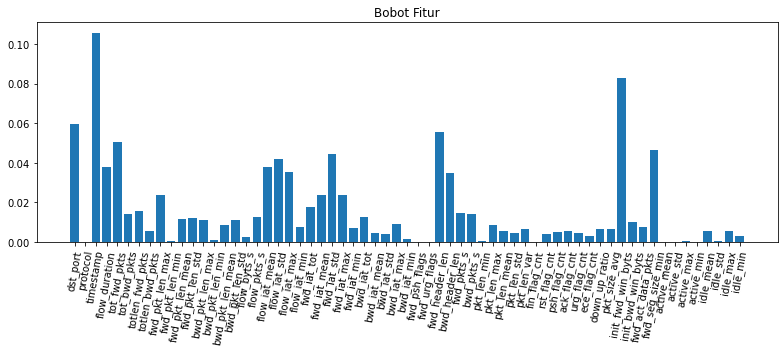

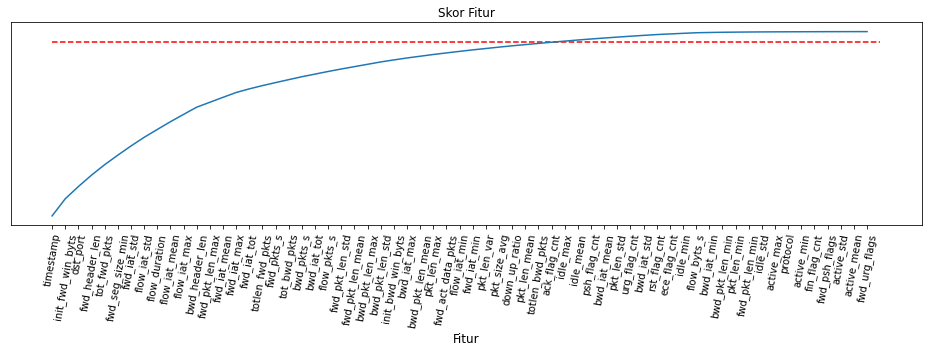

In [11]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 95

# vektor target
vektor_target = y_train['label']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih dan fitur dihapus
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus_rf,fitur_terpilih_rf = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

# hapus fitur dengan skor terendah
X_train_rf = X_train_norm.drop(fitur_dihapus_rf, axis=1)
X_test_rf = X_test_norm.drop(fitur_dihapus_rf, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [12]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual multi kelas
y_aktual_multi = y_test['label'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_rf.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_rf.columns),'fitur')

Fitur yang digunakan
['dst_port', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_max', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_var', 'ack_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min']

Jumlah fitur
39 fitur


### 69.2. Pemilihan jumlah 'tree'

In [13]:
# Pemilihan jumlah 'trees' #
# ======================== #

m_jlh = time.time()

# parameter yang digunakan
param_klf = [{'random_state':42, 'n_jobs':-1}]                
jlh_estimator = [10,15,20,25,30,35,40,45,50]

# hasil pelatihan
latih_eval_rf(param_klf, jlh_estimator, y_aktual_multi)

s_jlh = time.time()
print ("Lama waktu pencarian jumlah 'tree' : ", s_jlh - m_jlh)

jumlah 'trees' : 10
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 40.62620997428894
Lama waktu prediksi : 0.5863001346588135
hasil 'Accuracy'    : 0.9971642253315843
hasil 'f1-score'    : 0.9785579409216086

jumlah 'trees' : 15
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 54.19114923477173
Lama waktu prediksi : 0.869051456451416
hasil 'Accuracy'    : 0.9972006631686343
hasil 'f1-score'    : 0.9758497171197161

jumlah 'trees' : 20
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 73.30599570274353
Lama waktu prediksi : 1.0297176837921143
hasil 'Accuracy'    : 0.9971915537093718
hasil 'f1-score'    : 0.9758410002742546

jumlah 'trees' : 25
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 85.72392535209656
Lama waktu prediksi : 1.1876566410064697
hasil 'Accuracy'    : 0.9971924646552981
hasil 'f1-score'    : 0.9782989359448532

jumlah 'trees' : 30
hyperparameter : {'random_state': 42,

In [14]:
# list hasil pelatihan
print ('List hasil pelatihan')
print ('====================')
print ('hasil_waktu_latih    =', hasil_waktu_latih)
print ('hasil_waktu_prediksi =', hasil_waktu_pred)
print ('hasil_f1_macro       =', hasil_f1_macro)
print ('hasil_akurasi        =', hasil_akurasi)
print ('jumlah_estimator     =', jlh_estimator)

List hasil pelatihan
hasil_waktu_latih    = [40.62620997428894, 54.19114923477173, 73.30599570274353, 85.72392535209656, 98.74538254737854, 119.2491500377655, 141.67611694335938, 161.9422423839569, 176.2248296737671]
hasil_waktu_prediksi = [0.5863001346588135, 0.869051456451416, 1.0297176837921143, 1.1876566410064697, 1.4726207256317139, 1.6244029998779297, 2.037180185317993, 2.2599382400512695, 2.491398572921753]
hasil_f1_macro       = [0.9785579409216086, 0.9758497171197161, 0.9758410002742546, 0.9782989359448532, 0.9758483612850815, 0.974469051900708, 0.9744817876222506, 0.9774716685887088, 0.9789190664943279]
hasil_akurasi        = [0.9971642253315843, 0.9972006631686343, 0.9971915537093718, 0.9971924646552981, 0.9971988412767818, 0.9972252587086431, 0.9972343681679056, 0.9972289024923481, 0.9972298134382743]
jumlah_estimator     = [10, 15, 20, 25, 30, 35, 40, 45, 50]


#### 69.2.1. Plot hasil pengukuran


 PLOT WAKTU LATIH


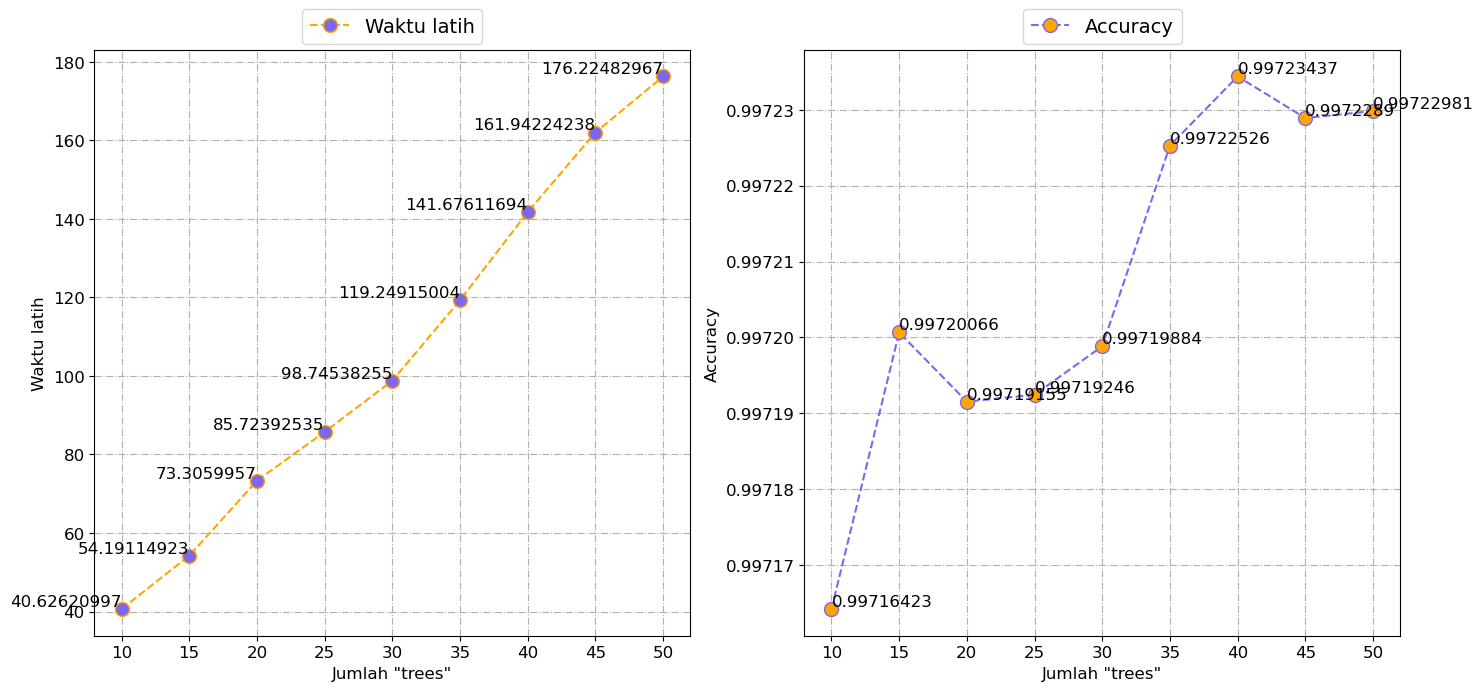


 PLOT WAKTU PREDIKSI


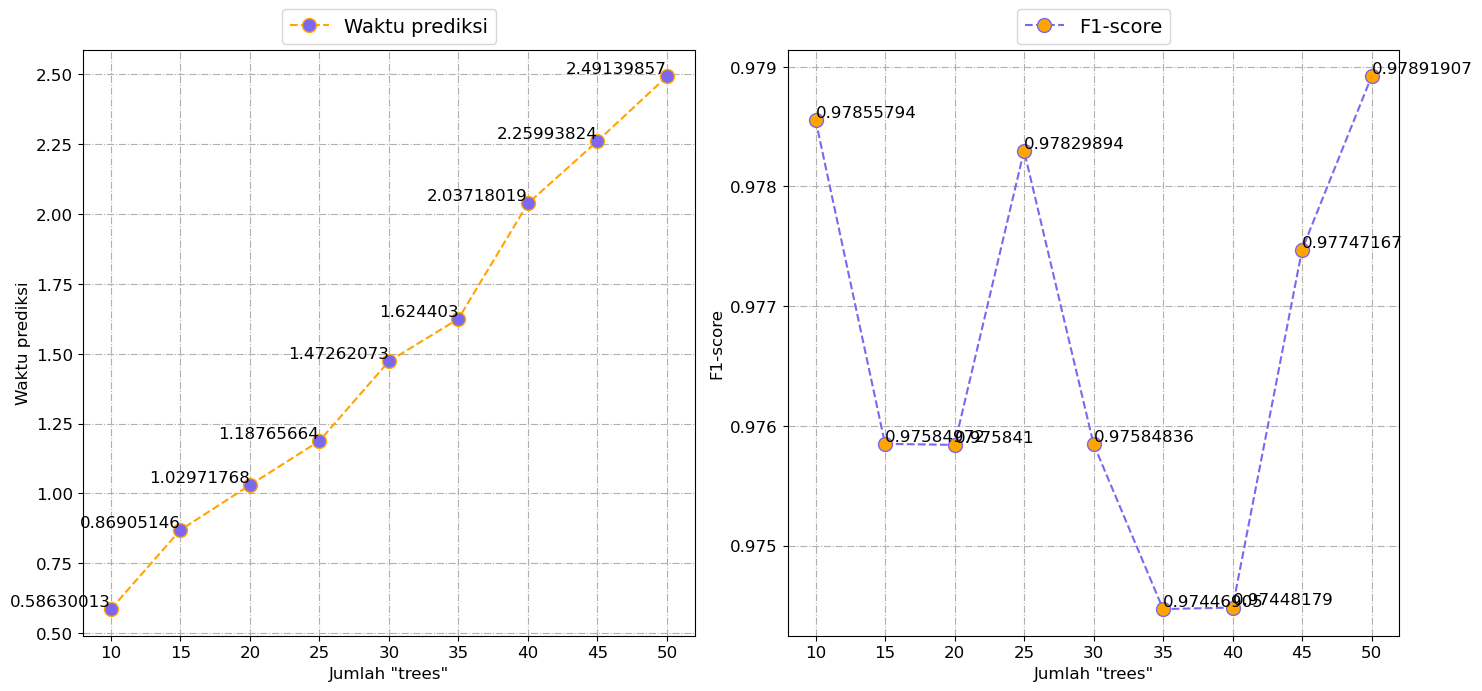


 PLOT WAKTU LATIH


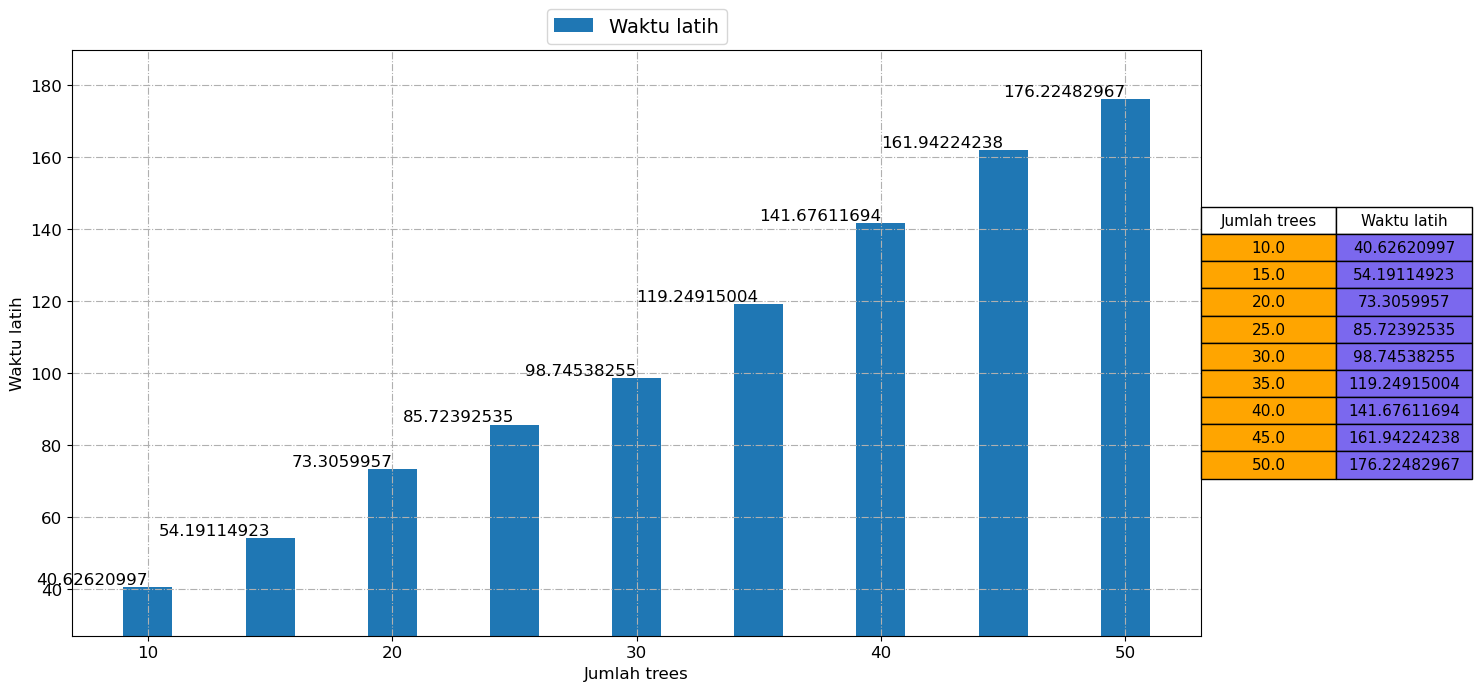


 PLOT WAKTU PREDIKSI


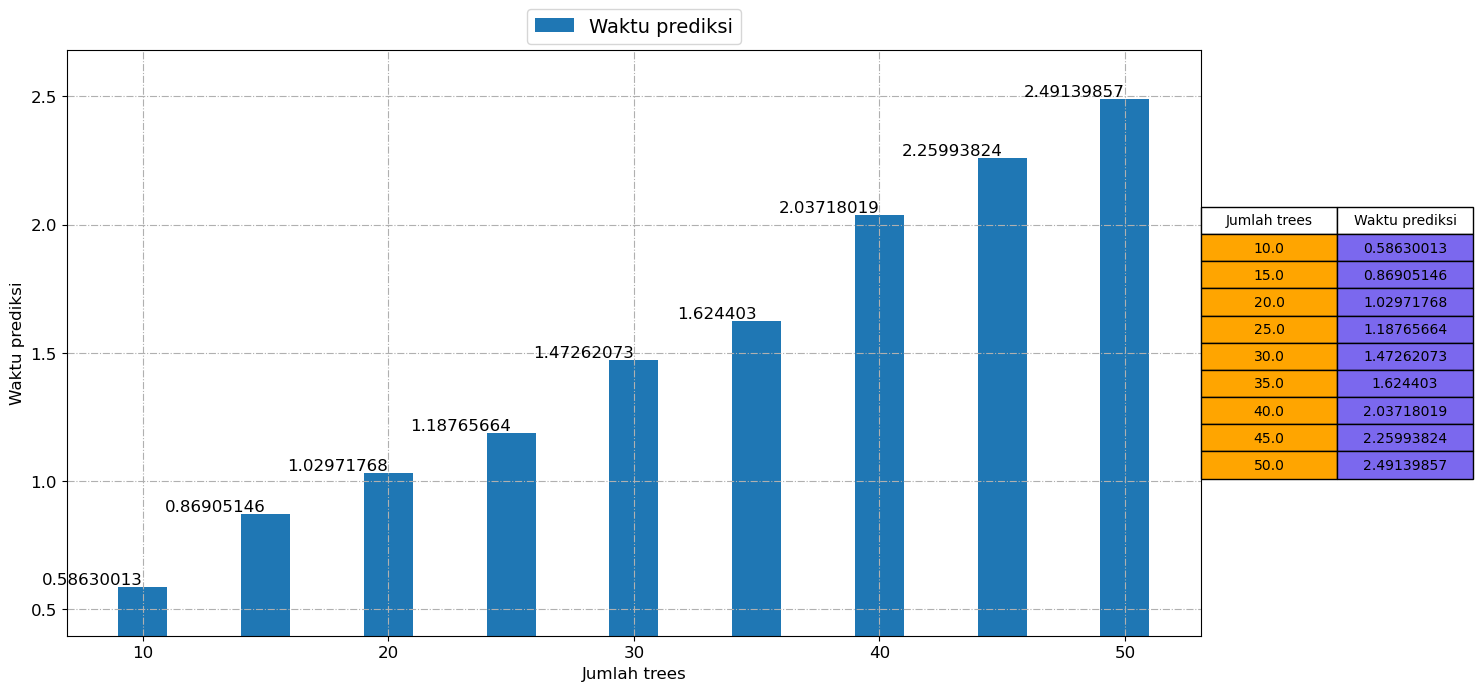


 PLOT ACCURACY


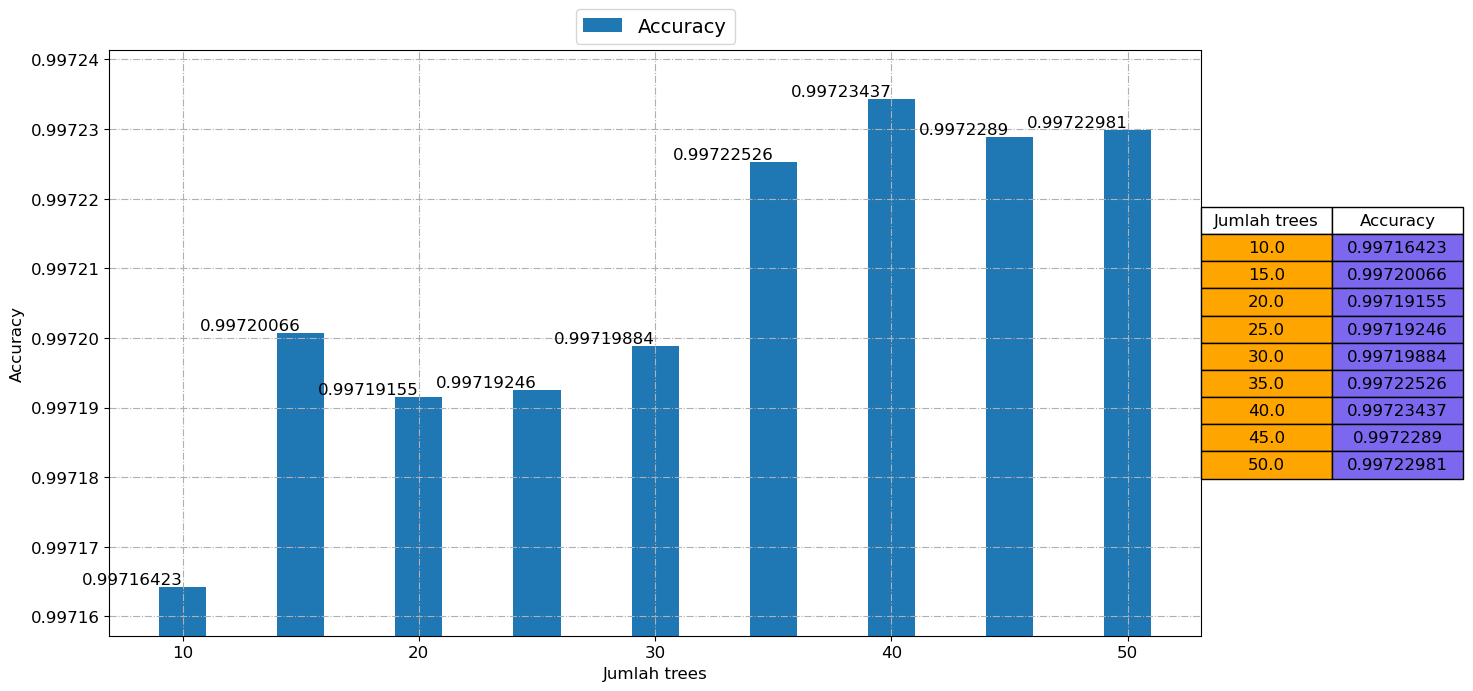


 PLOT F1-SCORE


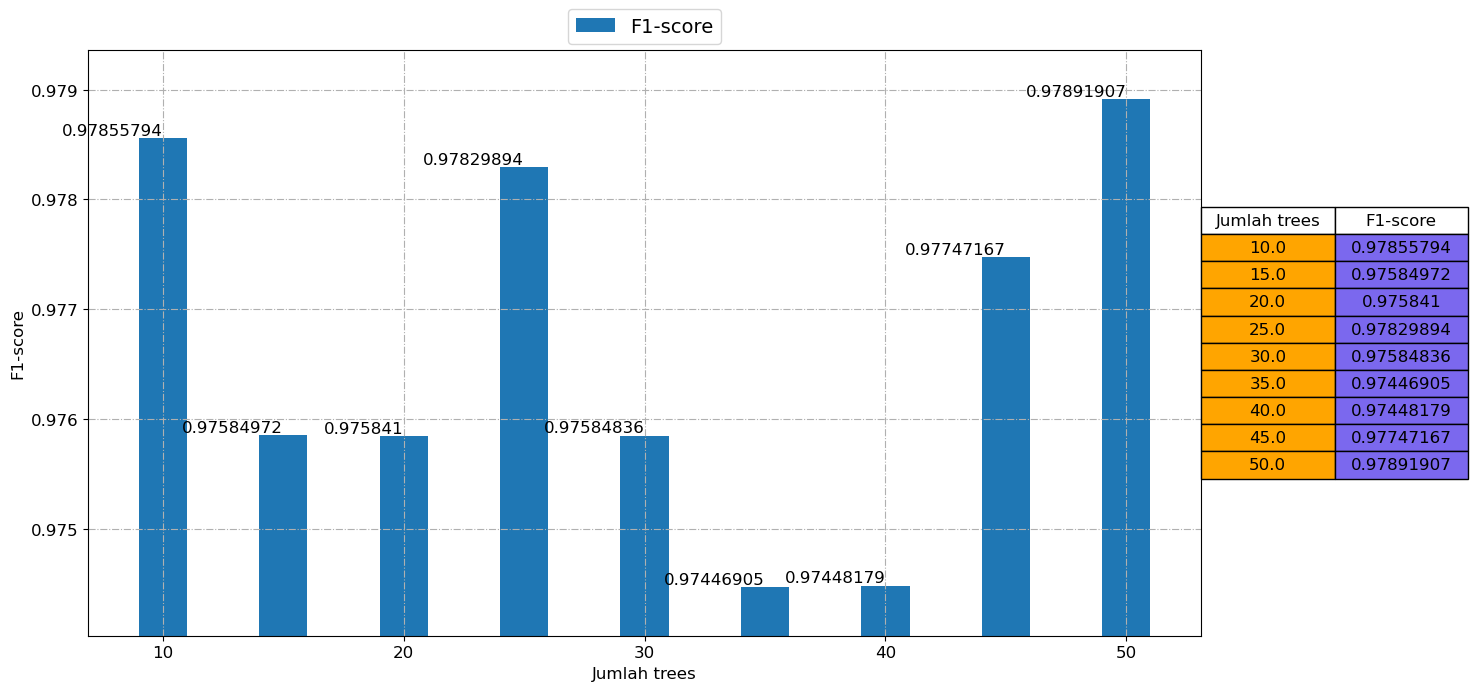

In [15]:
# Plot hasil pengukuran #
# ===================== #

# Plot waktu latih dan akurasi
plot_eval(hasil_waktu_latih,hasil_akurasi,jumlah_estimator,'Jumlah "trees"','Waktu latih','Accuracy')

# Plot waktu prediksi dan akurasi
plot_eval(hasil_waktu_pred,hasil_f1_macro,jumlah_estimator,'Jumlah "trees"','Waktu prediksi','F1-score')

# Plot waktu pelatihan
plot_eval(None,hasil_waktu_latih,jumlah_estimator,'Jumlah trees','Waktu latih',None)

# Plot waktu prediksi
plot_eval(None,hasil_waktu_pred,jumlah_estimator,'Jumlah trees','Waktu prediksi',None)

# Plot Akurasi
plot_eval(None,hasil_akurasi,jumlah_estimator,'Jumlah trees','Accuracy',None)

# plot F1
plot_eval(None,hasil_f1_macro,jumlah_estimator,'Jumlah trees','F1-score',None)

### 69.3. Hyperparameter tuning random forest

In [13]:
# Hyperparameter tuning random forest #
# =================================== #

m_hyper = time.time()

# hyperparameter yang digunakan untuk tuning
jlh_estimator     = [10]
max_features      = [5,9,12,15,18]
max_depth         = [None,5,10,15,20,25,30]
min_samples_split = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
min_samples_leaf  = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# pembangunan model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# jumlah acak kombinasi nilai hyperparameter
n_iter = 15

# validasi silang 5 lipatan
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

# random grid search
random_grid = {'n_estimators': jlh_estimator,'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,'max_features': max_features}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=n_iter, cv=cv, verbose=10, random_state=5, n_jobs=None, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
rf_random.fit(X_train_rf, y_train['label'])

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' : ", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 1/5; 1/15] END max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=0.743 total time=  34.2s
[CV 2/5; 1/15] START max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 2/5; 1/15] END max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=0.731 total time=  30.5s
[CV 3/5; 1/15] START max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 3/5; 1/15] END max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10;, score=0.743 total time=  29.6s
[CV 4/5; 1/15] START max_depth=5, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=10
[CV 4/5; 1/15] END max_depth=5, max_features=15, min_samples_leaf=3, min_samples_sp

[CV 4/5; 7/15] END max_depth=15, max_features=5, min_samples_leaf=7, min_samples_split=12, n_estimators=10;, score=0.925 total time=  26.5s
[CV 5/5; 7/15] START max_depth=15, max_features=5, min_samples_leaf=7, min_samples_split=12, n_estimators=10
[CV 5/5; 7/15] END max_depth=15, max_features=5, min_samples_leaf=7, min_samples_split=12, n_estimators=10;, score=0.928 total time=  26.2s
[CV 1/5; 8/15] START max_depth=25, max_features=15, min_samples_leaf=12, min_samples_split=17, n_estimators=10
[CV 1/5; 8/15] END max_depth=25, max_features=15, min_samples_leaf=12, min_samples_split=17, n_estimators=10;, score=0.944 total time=  54.7s
[CV 2/5; 8/15] START max_depth=25, max_features=15, min_samples_leaf=12, min_samples_split=17, n_estimators=10
[CV 2/5; 8/15] END max_depth=25, max_features=15, min_samples_leaf=12, min_samples_split=17, n_estimators=10;, score=0.931 total time=  56.9s
[CV 3/5; 8/15] START max_depth=25, max_features=15, min_samples_leaf=12, min_samples_split=17, n_estimato

[CV 2/5; 14/15] END max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10;, score=0.716 total time=  25.2s
[CV 3/5; 14/15] START max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10
[CV 3/5; 14/15] END max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10;, score=0.715 total time=  24.9s
[CV 4/5; 14/15] START max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10
[CV 4/5; 14/15] END max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10;, score=0.715 total time=  24.9s
[CV 5/5; 14/15] START max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10
[CV 5/5; 14/15] END max_depth=5, max_features=12, min_samples_leaf=12, min_samples_split=3, n_estimators=10;, score=0.716 total time=  25.2s
[CV 1/5; 15/15] START max_depth=10, max_features=5, min_samples_leaf=11, min_samples_split=13, n_estimator

In [14]:
# Hasil tuning hyperparameter #
# =========================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('Nilai F1 skor terbaik : %s' % rf_random.best_score_)
print ('Parameter terbaik     : %s' % rf_random.best_params_)
print ('Estimator terbaik     : %s' % rf_random.best_estimator_)
test_69_rf_new_params_2 = pd.DataFrame(rf_random.cv_results_)

# simpan hasil hyperparameter random forest
test_69_rf_new_params_2.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_69_rf_new_params_2.txt", index=False)

F1 skor dan parameter terbaik
Nilai F1 skor terbaik : 0.9675263461431465
Parameter terbaik     : {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': None}
Estimator terbaik     : RandomForestClassifier(max_features=12, min_samples_leaf=2,
                       min_samples_split=20, n_estimators=10, n_jobs=-1,
                       random_state=42)


### 69.4. Hyperparameter terbaik

In [13]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_rf = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_69_rf_new_params_2.txt")

# mengurutkan hyperparameter terbaik berdasarkan f1
hyperparam_rf = hyperparam_rf.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 hyperparameter terbaik berdasarkan f1')
print ('=======================================')
param = hyperparam_rf[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 hyperparameter terbaik berdasarkan f1


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': None}",46.043258,0.967526
1,2,"{'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 12, 'max_depth': 25}",45.154273,0.948345
2,3,"{'n_estimators': 10, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 5, 'max_depth': 20}",23.949470,0.941939
3,4,"{'n_estimators': 10, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 15, 'max_depth': 25}",51.325645,0.939683
4,5,"{'n_estimators': 10, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 5, 'max_depth': 15}",21.392300,0.931244


#### 69.4.1. Latih hyperparameter terbaik berdasarkan f1

In [14]:
param_rf = param['params'][0]
param_terbaik = [eval(param_rf)]       

# jumlah estimator
for n in param_terbaik:
    jlh_estimator = [n['n_estimators']]

param_terbaik

[{'n_estimators': 10,
  'min_samples_split': 20,
  'min_samples_leaf': 2,
  'max_features': 12,
  'max_depth': None}]

In [18]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')
print ('')
klf_f1, y_f1 = latih_eval_rf(param_terbaik, jlh_estimator, y_aktual_multi)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|

hyperparameter : {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': None}
Lama waktu latih    : 113.53789377212524
Lama waktu prediksi : 0.8455631732940674
hasil 'Accuracy'    : 0.997633362483603
hasil 'f1-score'    : 0.975980517125575



#### 69.4.2. Evaluasi model


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.997633362483603
Precision : 0.9849702397382101
Recall    : 0.9681487443658783
F1-score  : 0.975980517125575

metrik evaluasi :
                          precision    recall  f1-score   support

                  benign   0.997505  0.997785  0.997645    548880
                     bot   1.000000  0.999983  0.999991     57187
        brute_force__web   0.982456  0.949153  0.965517       118
        brute_force__xss   0.976744  0.913043  0.943820        46
        ddos_attack_hoic   1.000000  1.000000  1.000000    137202
    ddos_attack_loic_udp   1.000000  1.000000  1.000000       346
  ddos_attacks_loic_http   1.000000  1.000000  1.000000    115238
   dos_attacks_goldeneye   0.999880  0.999880  0.999880      8302
        dos_attacks_hulk   1.000000  0.999989  0.999995     92382
dos_attacks_slowhttptest   1.000000  1.000000  1.000000     27978
   dos_attacks_slowloris   0.999545  0.999545  0.999545      2198
          ftp_brutefor

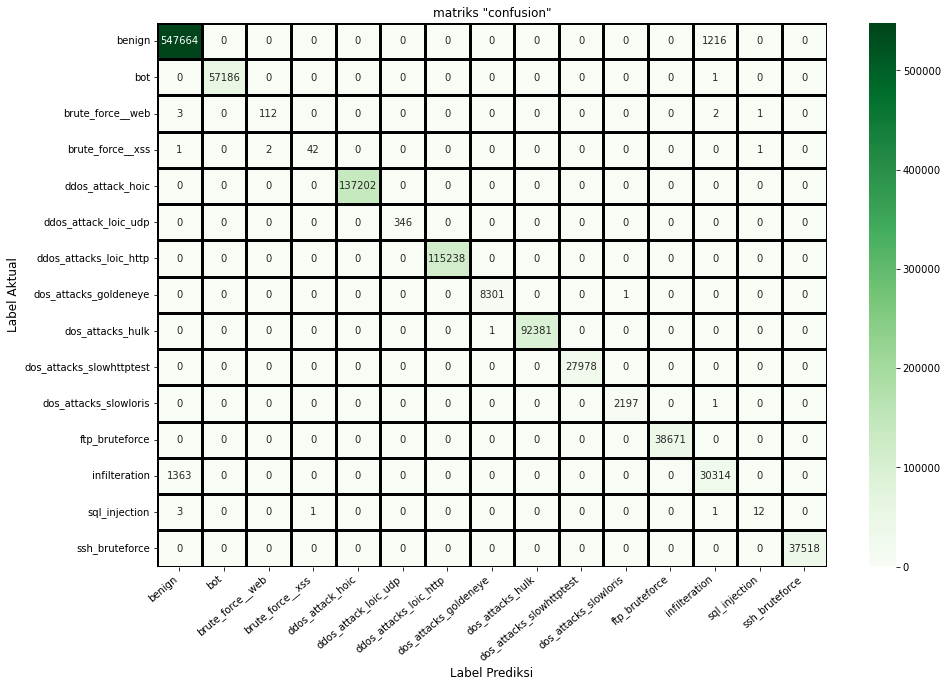

misklasifikasi kelas target:
                          misklasifikasi   total  persentase_misklasifikasi(%)
sql_injection                          5      17                     29.411765
brute_force__xss                       4      46                      8.695652
brute_force__web                       6     118                      5.084746
infilteration                       1363   31677                      4.302806
benign                              1216  548880                      0.221542
dos_attacks_slowloris                  1    2198                      0.045496
dos_attacks_goldeneye                  1    8302                      0.012045
bot                                    1   57187                      0.001749
dos_attacks_hulk                       1   92382                      0.001082
ddos_attack_hoic                       0  137202                      0.000000
ddos_attack_loic_udp                   0     346                      0.000000
ddos_attacks_loic_http 

In [17]:
# metrik evaluasi lapisan 3 berdasarkan f1
metrik (klf_f1, 2, y_aktual_multi, y_f1)

# misklasifikasi lapisan 3
misklasifikasi(y_aktual_multi, y_f1)

# =========================================

## Test 70

### 70.1. Seleksi fitur random forest - 99%

Fitur yang dihapus
['idle_min', 'flow_byts_s', 'bwd_iat_min', 'bwd_pkt_len_min', 'pkt_len_min', 'fwd_pkt_len_min', 'idle_std', 'active_max', 'protocol', 'active_min', 'fin_flag_cnt', 'fwd_psh_flags', 'active_std', 'active_mean', 'fwd_urg_flags']


Fitur dengan skor terbaik
                Fitur  Persentase skor  jumlah persentase
1           timestamp        10.560959          10.560959
2   init_fwd_win_byts         8.300108          18.861067
3            dst_port         5.944268          24.805335
4      fwd_header_len         5.547529          30.352864
5        tot_fwd_pkts         5.066573          35.419437
6    fwd_seg_size_min         4.625303          40.044740
7         fwd_iat_std         4.451333          44.496073
8        flow_iat_std         4.185843          48.681915
9       flow_duration         3.814342          52.496257
10      flow_iat_mean         3.767701          56.263958
11       flow_iat_max         3.553180          59.817138
12     bwd_header_len         

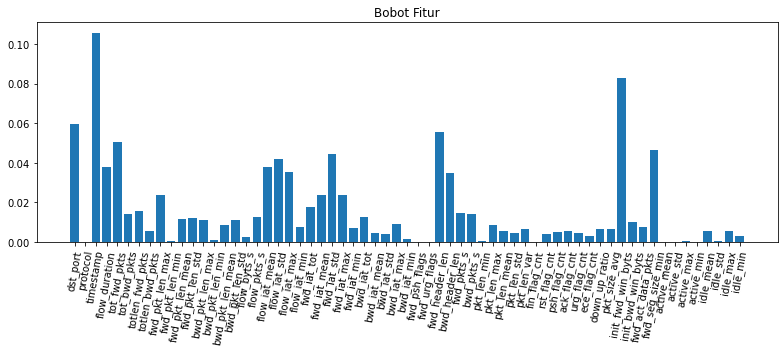

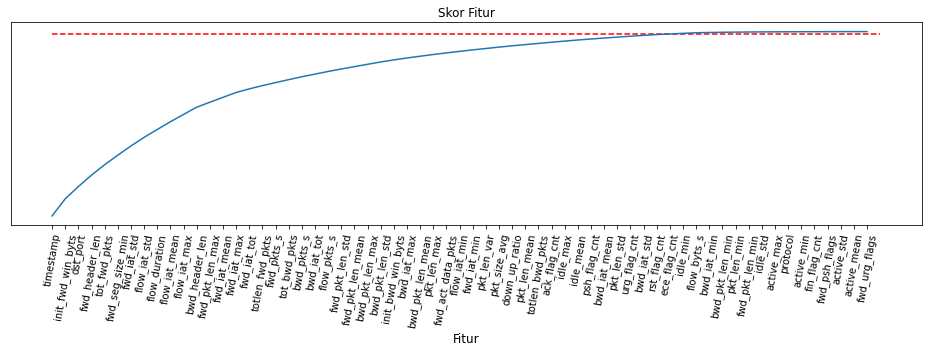

In [19]:
# Seleksi fitur dengan 'random forest' #
# ==================================== #

m_sf = time.time()

# ambang batas persentase skor
persentase_skor = 99

# vektor target
vektor_target = y_train['label']

# jumlah 'trees'
jumlah_trees = 100

# fitur terpilih dan fitur dihapus
klf = RandomForestClassifier(n_estimators=jumlah_trees, random_state=42, n_jobs=-1)
fit = klf.fit(X_train_norm, vektor_target)
fitur_dihapus_rf,fitur_terpilih_rf = fitur_terbaik (fit, persentase_skor, X_train_norm, 'rf')

# hapus fitur dengan skor terendah
X_train_rf = X_train_norm.drop(fitur_dihapus_rf, axis=1)
X_test_rf = X_test_norm.drop(fitur_dihapus_rf, axis=1)

s_sf = time.time()
print ('')
print ("Lama waktu seleksi fitur 'random forest' : ", s_sf - m_sf)

In [20]:
# label aktual dan jumlah fitur #
# ============================= #

# label aktual multi kelas
y_aktual_multi = y_test['label'].reset_index(drop=True)

# fitur dan jumlah fitur yang digunakan
print ('Fitur yang digunakan')
print ('====================')
print (list(X_train_rf.columns))
print ('')
print ('Jumlah fitur')
print ('============')
print (len(X_train_rf.columns),'fitur')

Fitur yang digunakan
['dst_port', 'timestamp', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'flow_pkts_s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s', 'bwd_pkts_s', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts', 'init_bwd_win_byts', 'fwd_act_data_pkts', 'fwd_seg_size_min', 'idle_mean', 'idle_max']

Jumlah fitur
48 fitur


### 70.2. Pemilihan jumlah 'tree'

In [25]:
# Pemilihan jumlah 'trees' #
# ======================== #

m_jlh = time.time()

# parameter yang digunakan
param_klf = [{'random_state':42, 'n_jobs':-1}]                
jlh_estimator = [10,15,20,25,30,35,40,45,50]

# hasil pelatihan
latih_eval_rf(param_klf, jlh_estimator, y_aktual_multi)

s_jlh = time.time()
print ("Lama waktu pencarian jumlah 'tree' : ", s_jlh - m_jlh)

jumlah 'trees' : 10
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 35.9110631942749
Lama waktu prediksi : 0.616788387298584
hasil 'Accuracy'    : 0.9970476242530243
hasil 'f1-score'    : 0.9538668827927462

jumlah 'trees' : 15
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 50.56570768356323
Lama waktu prediksi : 0.8105287551879883
hasil 'Accuracy'    : 0.9971642253315843
hasil 'f1-score'    : 0.9769727777096083

jumlah 'trees' : 20
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 70.25287652015686
Lama waktu prediksi : 1.0287394523620605
hasil 'Accuracy'    : 0.9971368969537968
hasil 'f1-score'    : 0.9811708910490445

jumlah 'trees' : 25
hyperparameter : {'random_state': 42, 'n_jobs': -1}
Lama waktu latih    : 83.1390266418457
Lama waktu prediksi : 1.2531719207763672
hasil 'Accuracy'    : 0.9971168561434193
hasil 'f1-score'    : 0.9812452276797132

jumlah 'trees' : 30
hyperparameter : {'random_state': 42, '

In [26]:
# list hasil pelatihan
print ('List hasil pelatihan')
print ('====================')
print ('hasil_waktu_latih    =', hasil_waktu_latih)
print ('hasil_waktu_prediksi =', hasil_waktu_pred)
print ('hasil_f1_macro       =', hasil_f1_macro)
print ('hasil_akurasi        =', hasil_akurasi)
print ('jumlah_estimator     =', jlh_estimator)

List hasil pelatihan
hasil_waktu_latih    = [35.9110631942749, 50.56570768356323, 70.25287652015686, 83.1390266418457, 98.17928695678711, 116.39707517623901, 128.2766923904419, 142.99977850914001, 159.34975290298462]
hasil_waktu_prediksi = [0.616788387298584, 0.8105287551879883, 1.0287394523620605, 1.2531719207763672, 1.4326438903808594, 1.6558043956756592, 1.8617115020751953, 2.1016430854797363, 2.323932409286499]
hasil_f1_macro       = [0.9538668827927462, 0.9769727777096083, 0.9811708910490445, 0.9812452276797132, 0.984312632730893, 0.9807648823791372, 0.9840757396559202, 0.9825810230794895, 0.9833583477017865]
hasil_akurasi        = [0.9970476242530243, 0.9971642253315843, 0.9971368969537968, 0.9971168561434193, 0.9971095685760093, 0.9970986372248943, 0.9971077466841568, 0.9971359860078706, 0.9971441845212068]
jumlah_estimator     = [10, 15, 20, 25, 30, 35, 40, 45, 50]


#### 70.2.1. Plot hasil pengukuran


 PLOT WAKTU LATIH


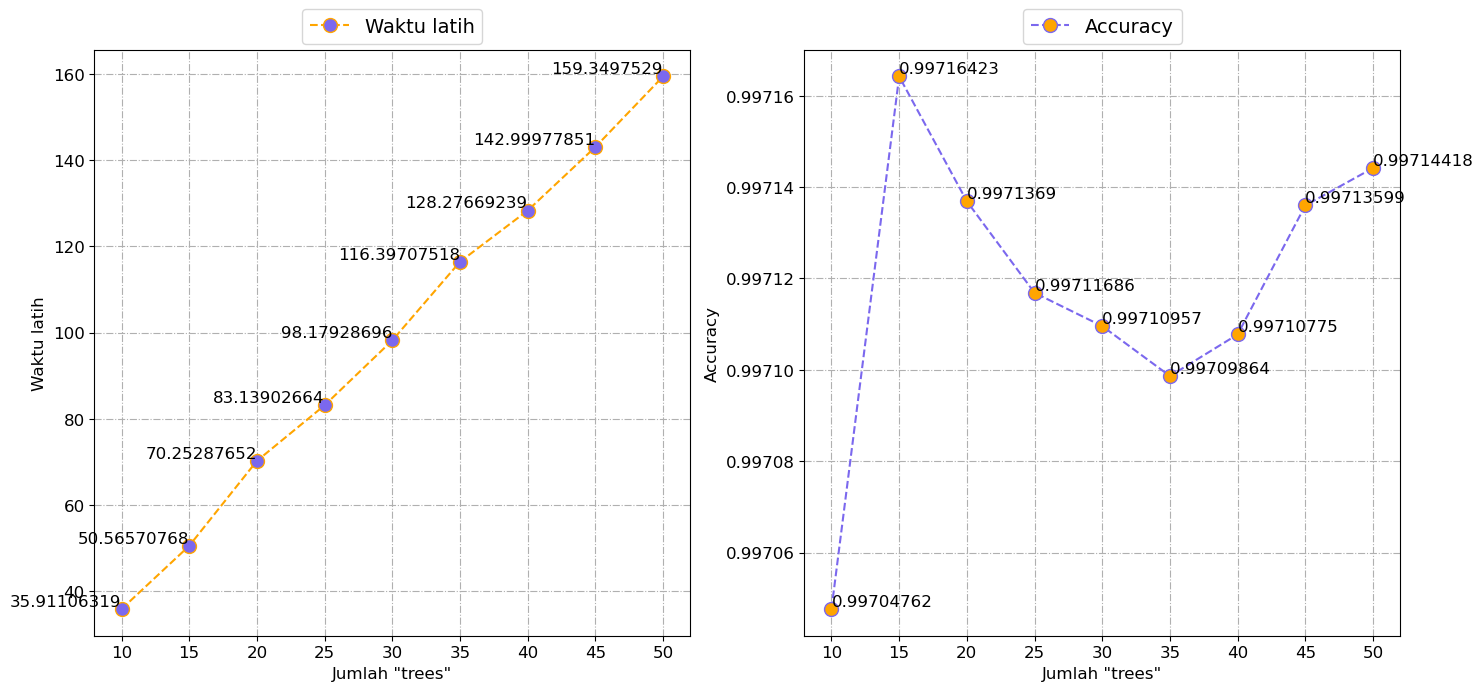


 PLOT WAKTU PREDIKSI


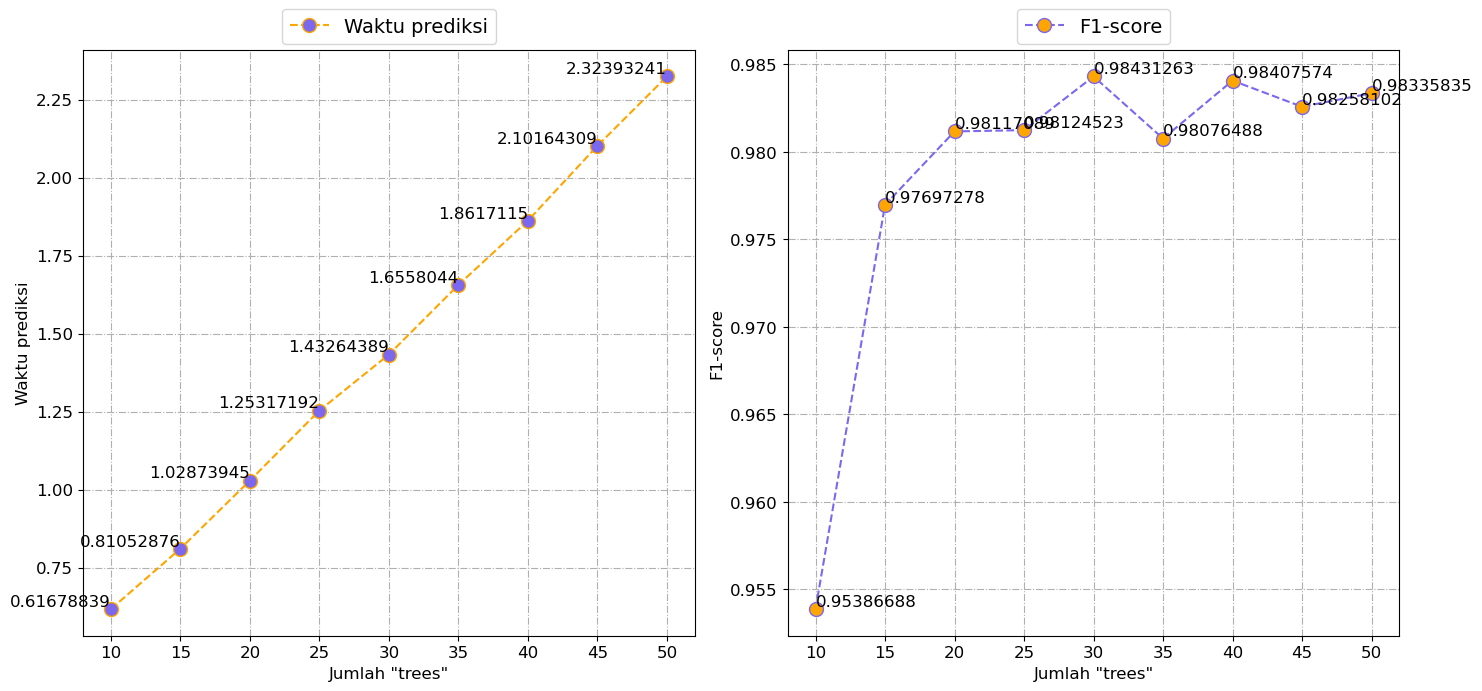


 PLOT WAKTU LATIH


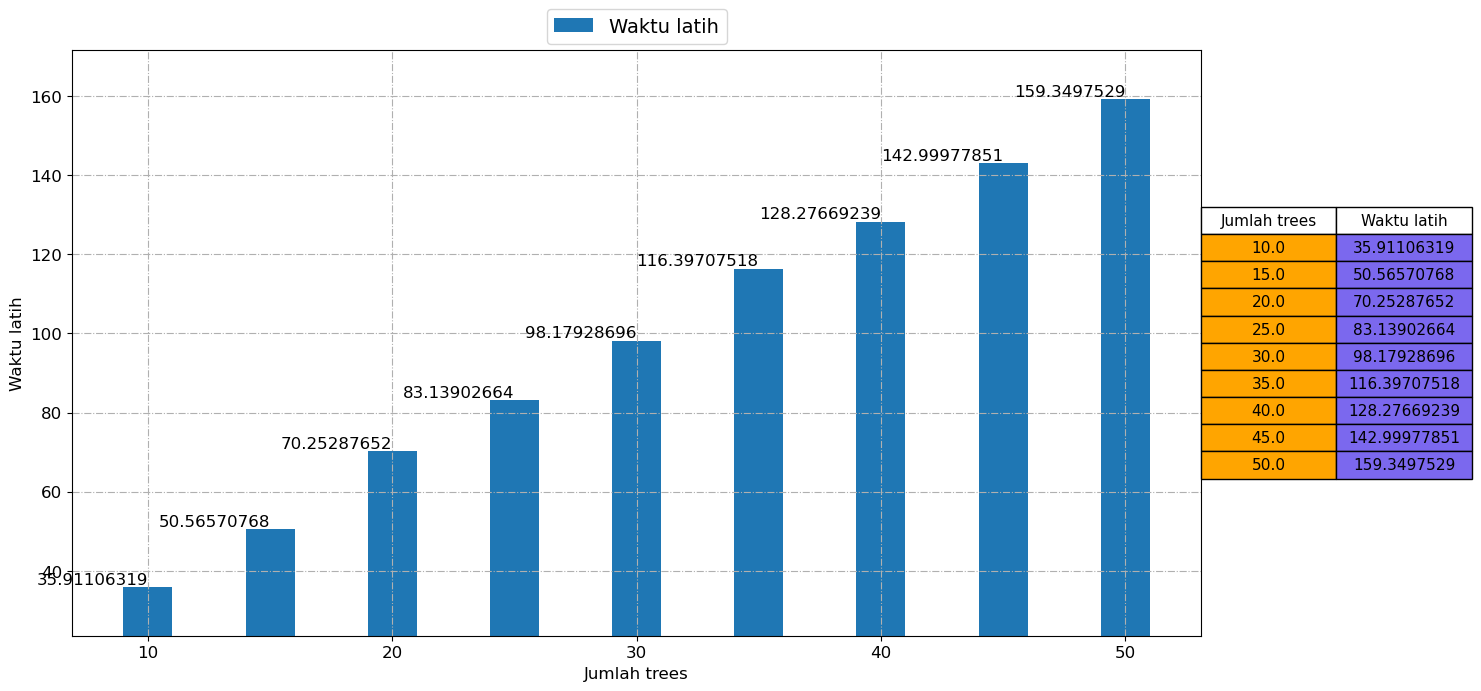


 PLOT WAKTU PREDIKSI


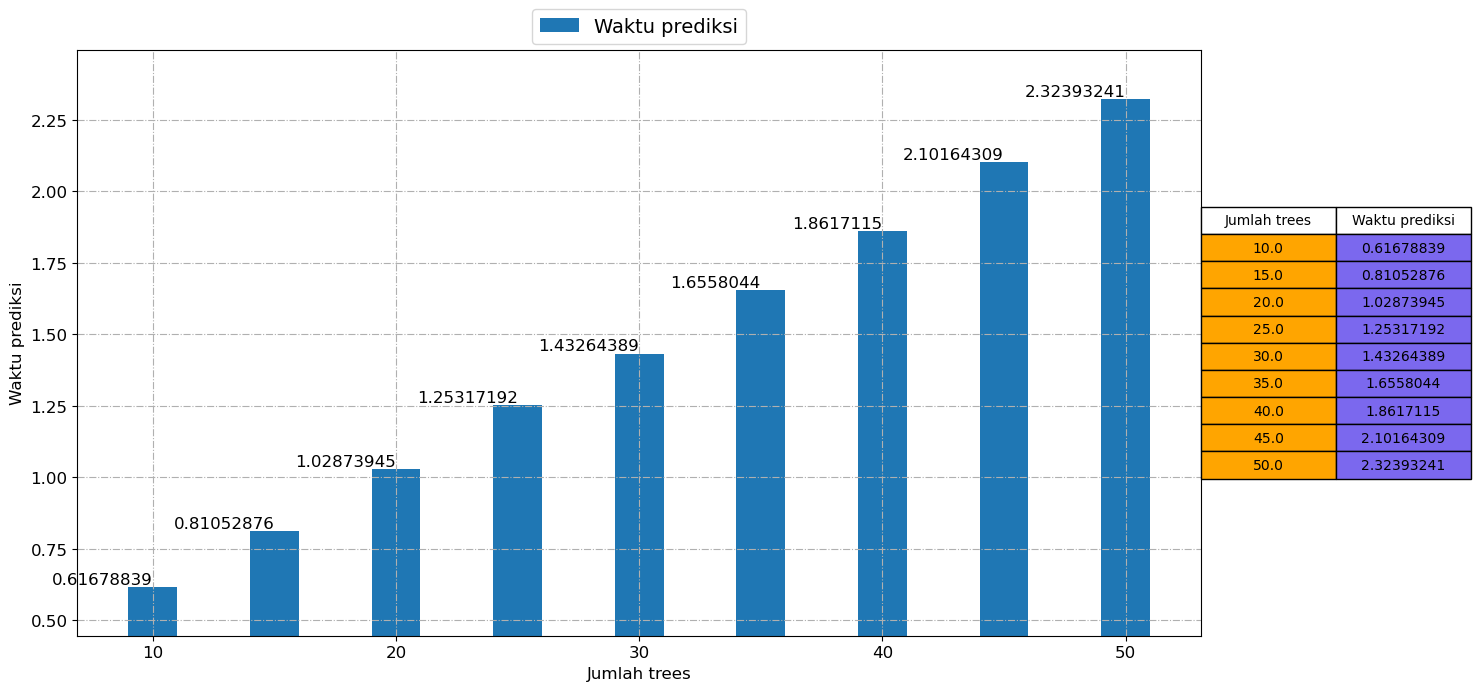


 PLOT ACCURACY


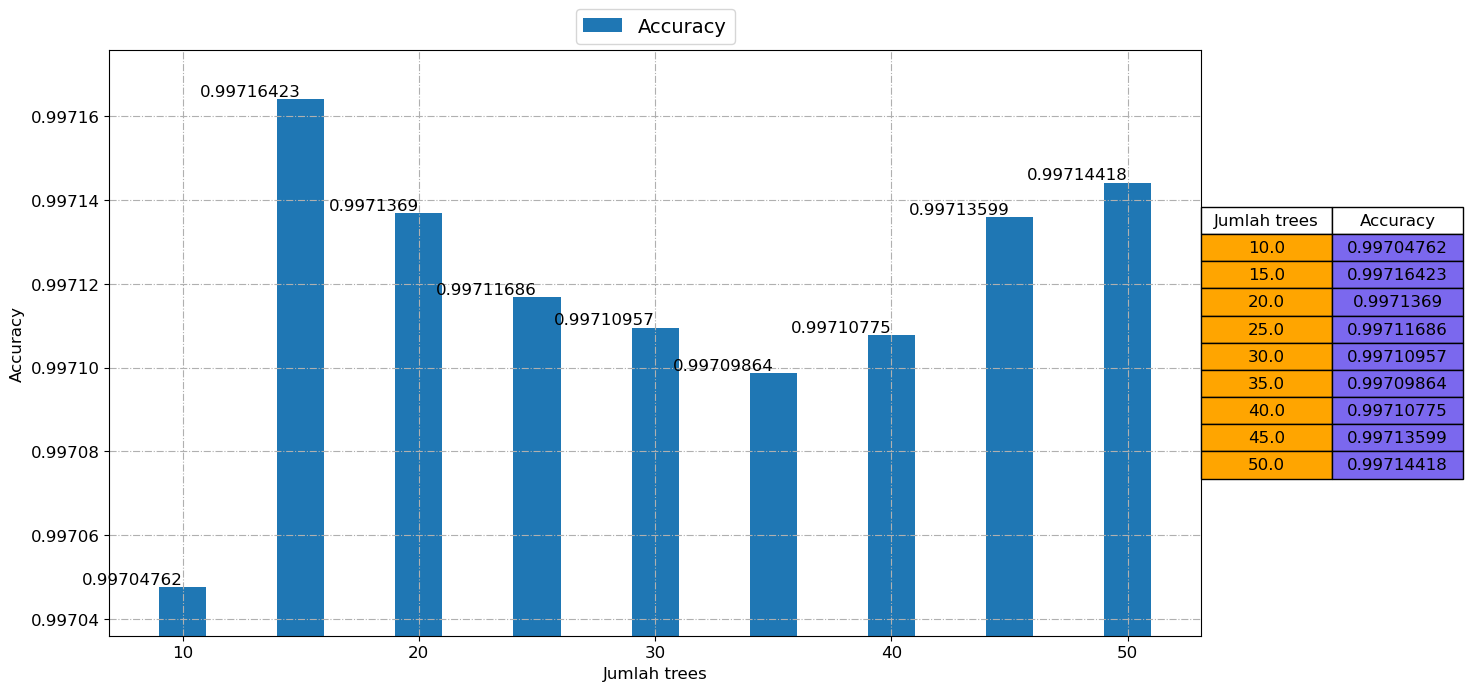


 PLOT F1-SCORE


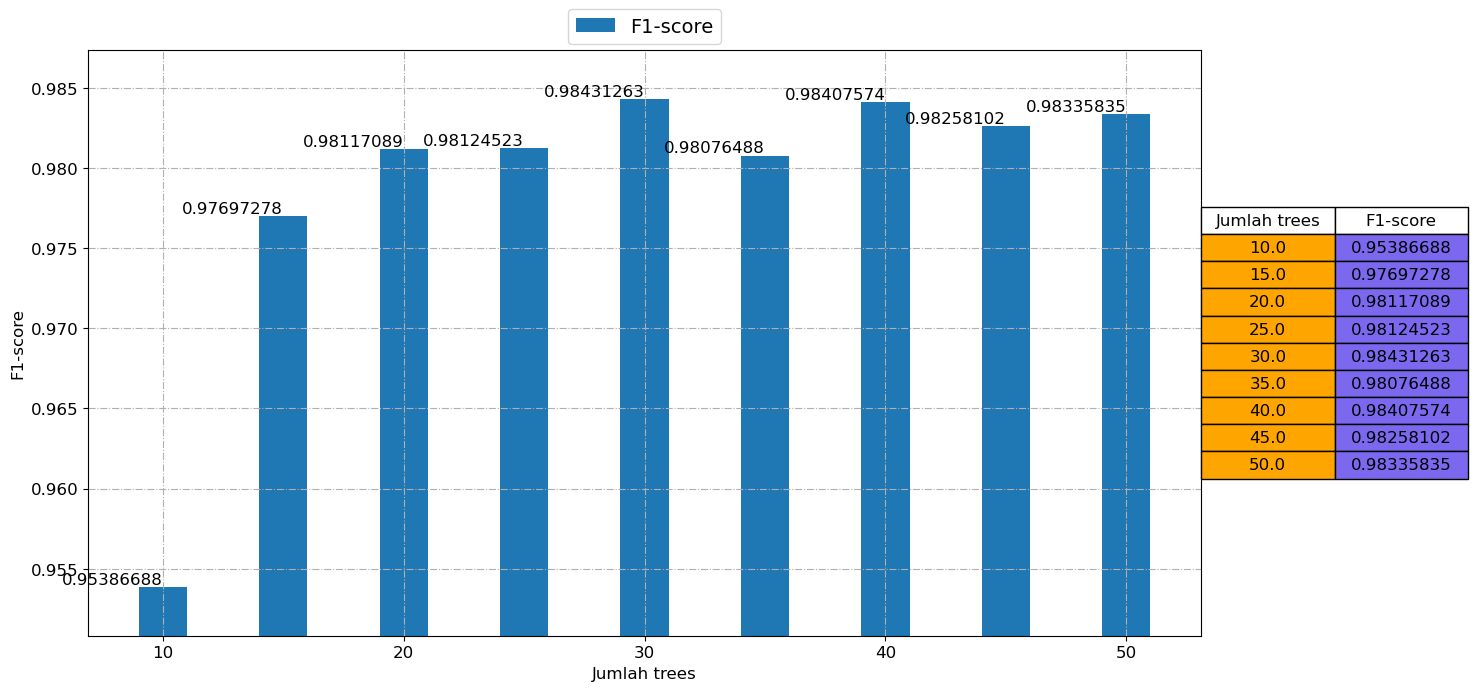

In [27]:
# Plot hasil pengukuran #
# ===================== #

# Plot waktu latih dan akurasi
plot_eval(hasil_waktu_latih,hasil_akurasi,jumlah_estimator,'Jumlah "trees"','Waktu latih','Accuracy')

# Plot waktu prediksi dan akurasi
plot_eval(hasil_waktu_pred,hasil_f1_macro,jumlah_estimator,'Jumlah "trees"','Waktu prediksi','F1-score')

# Plot waktu pelatihan
plot_eval(None,hasil_waktu_latih,jumlah_estimator,'Jumlah trees','Waktu latih',None)

# Plot waktu prediksi
plot_eval(None,hasil_waktu_pred,jumlah_estimator,'Jumlah trees','Waktu prediksi',None)

# Plot Akurasi
plot_eval(None,hasil_akurasi,jumlah_estimator,'Jumlah trees','Accuracy',None)

# plot F1
plot_eval(None,hasil_f1_macro,jumlah_estimator,'Jumlah trees','F1-score',None)

### 70.3. Hyperparameter tuning random forest

In [22]:
# Hyperparameter tuning random forest #
# =================================== #

m_hyper = time.time()

# hyperparameter yang digunakan untuk tuning
jlh_estimator     = [30]
max_features      = [5,9,12,15,18]
max_depth         = [None,5,10,15,20,25,30]
min_samples_split = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
min_samples_leaf  = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# pembangunan model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# jumlah acak kombinasi nilai hyperparameter
n_iter = 15

# validasi silang 5 lipatan
cv = 5

# tentukan f1 macro
f1_macro_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

# random grid search
random_grid = {'n_estimators': jlh_estimator,'max_depth': max_depth,'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,'max_features': max_features}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=n_iter, cv=cv, verbose=10, random_state=6, n_jobs=None, scoring=f1_macro_scorer)

# terapkan random grid pada data latih
rf_random.fit(X_train_rf, y_train['label'])

s_hyper = time.time()
print ("Lama waktu 'hyperparameter tuning' : ", s_hyper - m_hyper)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30
[CV 1/5; 1/15] END max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30;, score=0.774 total time= 1.1min
[CV 2/5; 1/15] START max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30
[CV 2/5; 1/15] END max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30;, score=0.773 total time=  58.0s
[CV 3/5; 1/15] START max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30
[CV 3/5; 1/15] END max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30;, score=0.774 total time=  55.0s
[CV 4/5; 1/15] START max_depth=5, max_features=12, min_samples_leaf=14, min_samples_split=8, n_estimators=30
[CV 4/5; 1/15] END max_depth=5, max_features=12, min_samples_leaf=14, min_samples_s

[CV 4/5; 7/15] END max_depth=15, max_features=12, min_samples_leaf=19, min_samples_split=4, n_estimators=30;, score=0.910 total time= 1.8min
[CV 5/5; 7/15] START max_depth=15, max_features=12, min_samples_leaf=19, min_samples_split=4, n_estimators=30
[CV 5/5; 7/15] END max_depth=15, max_features=12, min_samples_leaf=19, min_samples_split=4, n_estimators=30;, score=0.916 total time= 1.8min
[CV 1/5; 8/15] START max_depth=10, max_features=18, min_samples_leaf=20, min_samples_split=7, n_estimators=30
[CV 1/5; 8/15] END max_depth=10, max_features=18, min_samples_leaf=20, min_samples_split=7, n_estimators=30;, score=0.913 total time= 2.0min
[CV 2/5; 8/15] START max_depth=10, max_features=18, min_samples_leaf=20, min_samples_split=7, n_estimators=30
[CV 2/5; 8/15] END max_depth=10, max_features=18, min_samples_leaf=20, min_samples_split=7, n_estimators=30;, score=0.907 total time= 2.0min
[CV 3/5; 8/15] START max_depth=10, max_features=18, min_samples_leaf=20, min_samples_split=7, n_estimators

[CV 2/5; 14/15] END max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30;, score=0.958 total time= 2.7min
[CV 3/5; 14/15] START max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30
[CV 3/5; 14/15] END max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30;, score=0.966 total time= 2.5min
[CV 4/5; 14/15] START max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30
[CV 4/5; 14/15] END max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30;, score=0.945 total time= 2.6min
[CV 5/5; 14/15] START max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30
[CV 5/5; 14/15] END max_depth=30, max_features=15, min_samples_leaf=7, min_samples_split=6, n_estimators=30;, score=0.941 total time= 2.5min
[CV 1/5; 15/15] START max_depth=30, max_features=5, min_samples_leaf=3, min_samples_split=15, n_estimators

In [23]:
# Hasil tuning hyperparameter #
# =========================== #

# hasil
print ('F1 skor dan parameter terbaik')
print ('=============================')
print ('Nilai F1 skor terbaik : %s' % rf_random.best_score_)
print ('Parameter terbaik     : %s' % rf_random.best_params_)
print ('Estimator terbaik     : %s' % rf_random.best_estimator_)
test_70_rf_new_params_2 = pd.DataFrame(rf_random.cv_results_)

# simpan hasil hyperparameter random forest
test_70_rf_new_params_2.to_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_70_rf_new_params_2.txt", index=False)

F1 skor dan parameter terbaik
Nilai F1 skor terbaik : 0.9679959561122755
Parameter terbaik     : {'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 12, 'max_depth': 30}
Estimator terbaik     : RandomForestClassifier(max_depth=30, max_features=12, min_samples_leaf=4,
                       min_samples_split=9, n_estimators=30, n_jobs=-1,
                       random_state=42)


### 70.4. Hyperparameter terbaik

In [21]:
# 5 hyperparameter terbaik #
# ======================== #

# hyperparameter terbaik
hyperparam_rf = pd.read_csv("G:\\Universitas Indonesia\\Rancangan Paper\\Dataset CSE-CIC-IDS2018-AWS\\CIC2018\\test_70_rf_new_params_2.txt")

# mengurutkan hyperparameter terbaik berdasarkan f1
hyperparam_rf = hyperparam_rf.sort_values("rank_test_score")

# menampilkan 5 hyperparameter terbaik
print ('5 hyperparameter terbaik berdasarkan f1')
print ('=======================================')
param = hyperparam_rf[['rank_test_score','params','mean_fit_time','mean_test_score']].reset_index(drop=True)
#param = param[['params']]
param.head(5)

5 hyperparameter terbaik berdasarkan f1


,rank_test_score,params,mean_fit_time,mean_test_score
0,1,"{'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 12, 'max_depth': 30}",127.950401,0.967996
1,2,"{'n_estimators': 30, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 15, 'max_depth': 25}",148.294049,0.960955
2,3,"{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 15, 'max_depth': 20}",144.488322,0.954016
3,4,"{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 15, 'max_depth': 30}",148.283406,0.953507
4,5,"{'n_estimators': 30, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 5, 'max_depth': 25}",64.005395,0.946201


#### 70.4.1. Latih hyperparameter terbaik berdasarkan f1

In [22]:
param_rf = param['params'][0]
param_terbaik = [eval(param_rf)]       

# jumlah estimator
for n in param_terbaik:
    jlh_estimator = [n['n_estimators']]

param_terbaik

[{'n_estimators': 30,
  'min_samples_split': 9,
  'min_samples_leaf': 4,
  'max_features': 12,
  'max_depth': 30}]

In [23]:
print ('|=======================================|')
print ("| Hyperparameter terbaik berdasarkan f1 |")
print ('|=======================================|')
print ('')
klf_f1, y_f1 = latih_eval_rf(param_terbaik, jlh_estimator, y_aktual_multi)

|=======================================|
| Hyperparameter terbaik berdasarkan f1 |
|=======================================|

hyperparameter : {'n_estimators': 30, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 12, 'max_depth': 30}
Lama waktu latih    : 283.66767168045044
Lama waktu prediksi : 2.0515360832214355
hasil 'Accuracy'    : 0.9977864013992129
hasil 'f1-score'    : 0.9666080789869752



#### 70.4.2. Evaluasi model


Accuracy, Precision, Recall dan F1-score :
Accuracy  : 0.9977864013992129
Precision : 0.9806617215585683
Recall    : 0.9568317789667699
F1-score  : 0.9666080789869752

metrik evaluasi :
                          precision    recall  f1-score   support

                  benign   0.997381  0.998222  0.997801    548880
                     bot   1.000000  0.999965  0.999983     57187
        brute_force__web   0.949580  0.957627  0.953586       118
        brute_force__xss   0.976744  0.913043  0.943820        46
        ddos_attack_hoic   1.000000  1.000000  1.000000    137202
    ddos_attack_loic_udp   1.000000  1.000000  1.000000       346
  ddos_attacks_loic_http   1.000000  1.000000  1.000000    115238
   dos_attacks_goldeneye   0.999880  0.999880  0.999880      8302
        dos_attacks_hulk   1.000000  0.999989  0.999995     92382
dos_attacks_slowhttptest   1.000000  1.000000  1.000000     27978
   dos_attacks_slowloris   0.999545  0.999545  0.999545      2198
          ftp_brutef

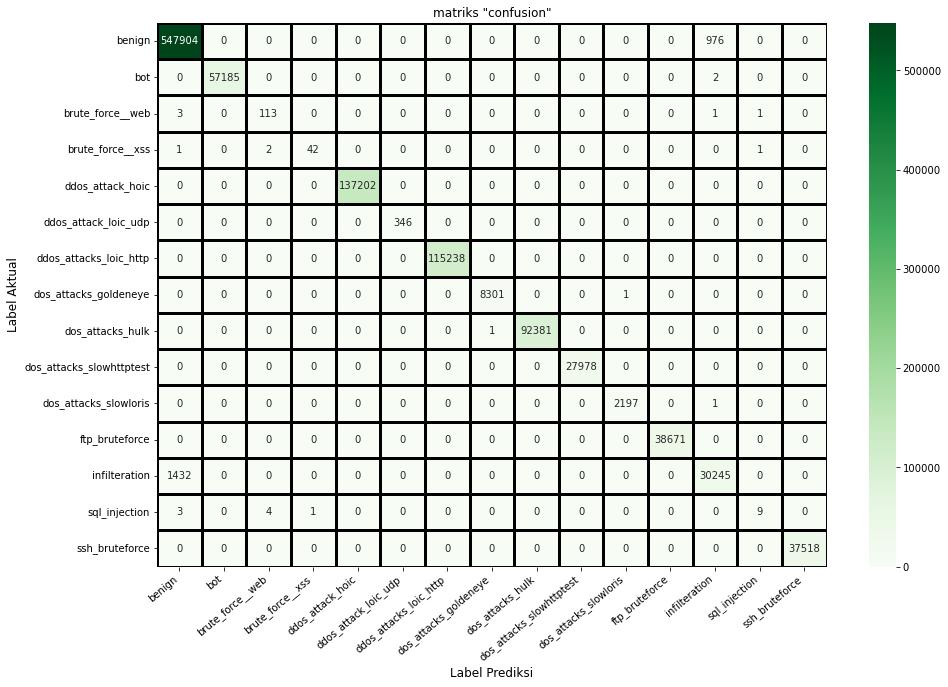

misklasifikasi kelas target:
                          misklasifikasi   total  persentase_misklasifikasi(%)
sql_injection                          8      17                     47.058824
brute_force__xss                       4      46                      8.695652
infilteration                       1432   31677                      4.520630
brute_force__web                       5     118                      4.237288
benign                               976  548880                      0.177817
dos_attacks_slowloris                  1    2198                      0.045496
dos_attacks_goldeneye                  1    8302                      0.012045
bot                                    2   57187                      0.003497
dos_attacks_hulk                       1   92382                      0.001082
ddos_attack_hoic                       0  137202                      0.000000
ddos_attack_loic_udp                   0     346                      0.000000
ddos_attacks_loic_http 

In [24]:
# metrik evaluasi lapisan 3 berdasarkan f1
metrik (klf_f1, 2, y_aktual_multi, y_f1)

# misklasifikasi lapisan 3
misklasifikasi(y_aktual_multi, y_f1)